# GRU Time Series - Stock Price Prediction
## Part 3 - Model Training
In this notebook, we import the scaled dataset files, prepare them in a format suitable for GRU modeling, and proceed to train the GRU model.

> **INPUT**: Scaled dataset files for training, validation, and testing periods, as processed in the preceding phase. <br/>
> **OUTPUT**: Trained GRU model and analysis of its performance.

### 1. INITIALIZATION

In [1]:
import tensorflow as tf 
print(tf.__version__)


2.13.0


In [70]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

### 2. LOADING DATASETS

In [71]:
# Prepare data file location and name
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [72]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (985, 6)
Validation Dataset Shape: (271, 6)
Testing Dataset Shape: (251, 6)


In [73]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close    Volume        Date
0  0.070917  0.063765  0.079504  0.061306  0.279169  2019-10-02
1  0.062345  0.059746  0.075039  0.067027  0.280511  2019-10-03
2  0.068348  0.071102  0.088516  0.077842  0.179524  2019-10-04
3  0.074663  0.074535  0.095864  0.077167  0.109198  2019-10-07
4  0.071225  0.068382  0.088435  0.067691  0.152428  2019-10-08
Validation Dataset:
       Open      High       Low     Close    Volume        Date
0  0.864360  0.862789  0.859415  0.857895  0.107146  2023-09-01
1  0.844267  0.850508  0.855585  0.856975  0.118797  2023-09-05
2  0.850073  0.851625  0.846816  0.843285  0.097711  2023-09-06
3  0.825688  0.842491  0.839458  0.851765  0.110497  2023-09-07
4  0.838512  0.851980  0.858710  0.861981  0.119683  2023-09-08
Testing Dataset:
       Open      High       Low     Close    Volume        Date
0  1.175804  1.190377  1.165506  1.185176  0.128694  2024-10-01
1  1.164669  1.174506  1.169042  1.173807  0.0639

### 3. DATA PREPROCESSING

The dataset has already undergone the primary preprocessing and transformation in the pervious phase. This section is only to display the data and extract features and dates.

In [74]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [75]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [76]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

### 4. CONSTRUCTING DATA STRUCTURE

Given that we are addressing a time series problem involving multiple predictors, our task involves constructing and reshaping the input data to suit the LSTM model.

This entails setting a sliding time window (sequence size) that determines the number of past observations used to predict the subsequent value.

In this experiment, we employ a sequence of previous samples (financial days) of all variables to forecast the opening price on the following day.

In [77]:
# Define a method to construct the input data X and Y
def construct_gru_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [78]:
# Define the sequence size
sequence_size = 60
target_attr_idx = features.index("Close")  
# Construct training data
X_train, y_train = construct_gru_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [79]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [80]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1507, 5)

 Data Train Scaled: (985, 5)
> Data Train X: (925, 60, 5)
> Data Train y: (925,)

 Data Validate Scaled: (271, 5)
> Data Validate X: (271, 60, 5)
> Data Validate y: (271,)

 Data Test Scaled: (251, 5)
> Data Test X: (251, 60, 5)
> Data Test y: (251,)


### 5. TRAINING Transformer MODEL

#### Building Transformer Model

In [81]:
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, Input
from keras.callbacks import ModelCheckpoint

# Initialize GRU model
regressor = Sequential()

# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# First GRU layer + Dropout
regressor.add(GRU(units=100, return_sequences=True))
regressor.add(Dropout(rate=0.2))

# Second GRU layer + Dropout
regressor.add(GRU(units=100, return_sequences=True))
regressor.add(Dropout(rate=0.2))



# Fourth GRU layer (final one without return_sequences) + Dropout
regressor.add(GRU(units=100))
regressor.add(Dropout(rate=0.2))

# Output layer
regressor.add(Dense(units=1))

# Compile
regressor.compile(optimizer="adam", loss="mean_squared_error")

regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 60, 100)           32100     
                                                                 
 dropout_11 (Dropout)        (None, 60, 100)           0         
                                                                 
 gru_12 (GRU)                (None, 60, 100)           60600     
                                                                 
 dropout_12 (Dropout)        (None, 60, 100)           0         
                                                                 
 gru_13 (GRU)                (None, 100)               60600     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

#### Training Model

In [82]:
# Prepare checkpoint
model_location = "../models/"
model_name = "google_stock_price_gru.model.h5"

best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
    save_format="h5"
)





In [83]:
# Train GRU
history = regressor.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=25,
    batch_size=64,
    callbacks=[best_model_checkpoint_callback]
)


Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 0.0767
Epoch 1: val_loss improved from inf to 0.03446, saving model to ../models\google_stock_price_gru.model.h5
15/15 [==============================] - 13s 337ms/step - loss: 0.0767 - val_loss: 0.0345
Epoch 2/25


c:\Users\DeLL\Documents\GitHub\time-series-stock-prediction\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.03446 to 0.02119, saving model to ../models\google_stock_price_gru.model.h5
15/15 [==============================] - 3s 195ms/step - loss: 0.0088 - val_loss: 0.0212
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.0052
Epoch 3: val_loss improved from 0.02119 to 0.00746, saving model to ../models\google_stock_price_gru.model.h5
15/15 [==============================] - 3s 205ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 4/25
15/15 [==============================] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss improved from 0.00746 to 0.00345, saving model to ../models\google_stock_price_gru.model.h5
15/15 [==============================] - 3s 200ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 5/25
15/15 [==============================] - ETA: 0s - loss: 0.0041
Epoch 5: val_loss did not improve from 0.00345
15/15 [==============================] - 3s 182ms/step - loss: 0.00

#### Performance Evaluation

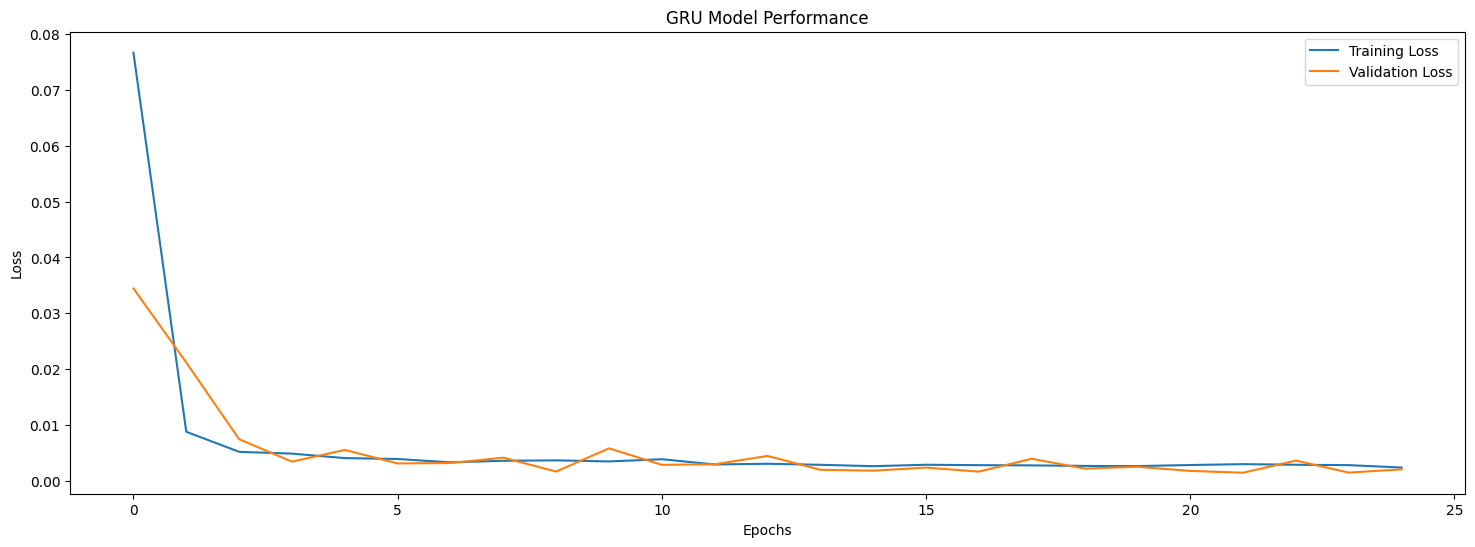

In [84]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


The chart above highlights the following observations:
- Training loss values decrease over the epochs, starting from a higher value and gradually decreasing. This indicates that the model is learning to fit the training data better as training progresses.
- Similarly, the validation loss values also decrease initially, indicating improvement in the model's ability to generalize to unseen data (validation set).
- Some fluctuations in the validation loss have been observed, which is quite justifiable due to the high variations and complexity in the price performance over time.
- There are no signs of overfitting since both loss values are continuously decreasing along with each other over the epochs.
- Validation loss has maintained lower values than training loss across almost the whole training period, which is quite normal due to the complexity/size of training data.

### 6. MODEL INFERENCE

The LSTM model has been trained and evaluated, making it ready to forecast future price trends.

As mentioned earlier, we will employ our model to predict Google stock prices during the testing period. To thoroughly assess the model's performance, we will forecast stock performance for the entire period, including testing samples, and compare these predictions with actual prices.

#### Load Best Model

In [85]:
# Prepare model location and name
model_location = "..//models//"
model_name = "google_stock_price_gru.model.h5"

# Load the best performing model
best_model = load_model(model_location + model_name)

#### Model Prediction

In [86]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

8/8 [==============================] - 0s 46ms/step


#### Inverse Scaling

One important thing to consider is the scale of the datasets, because the model was trained on scaled data that needs to be transformed back to its original price range.

Therefore, we have to load the same scaler used for transforming the original dataset and apply it to restore the prediction outputs to their actual distribution.

In [87]:
# Prepare scaler model name and location
scaler_model_location = "..//models//"
scaler_model_name = "google_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

The scaler was initially fitted on data with 6 columns encompassing all the features considered. However, during the inverse transformation process, our focus is solely on transforming the "Open" price.

To circumvent potential errors triggered by the inverse_transform API, we create a container structure of the necessary shape. We populate the first column with predictions and subsequently disregard the others.

In [88]:
n_features = sc.n_features_in_  # 5

# Training set inverse transform
y_train_inv = sc.inverse_transform(
    np.concatenate((y_train.reshape(-1, 1), np.ones((len(y_train), n_features - 1))), axis=1)
)[:, 0]

# Validation set inverse transform
y_validate_inv = sc.inverse_transform(
    np.concatenate((y_validate.reshape(-1, 1), np.ones((len(y_validate), n_features - 1))), axis=1)
)[:, 0]

# Test set inverse transform
y_test_inv = sc.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.ones((len(y_test), n_features - 1))), axis=1)
)[:, 0]

# Predicted values inverse transform
y_train_predict_inv = sc.inverse_transform(
    np.concatenate((y_train_predict, np.ones((len(y_train_predict), n_features - 1))), axis=1)
)[:, 0]

y_validate_predict_inv = sc.inverse_transform(
    np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), n_features - 1))), axis=1)
)[:, 0]

y_test_predict_inv = sc.inverse_transform(
    np.concatenate((y_test_predict, np.ones((len(y_test_predict), n_features - 1))), axis=1)
)[:, 0]


#### Display Predictions

In [89]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

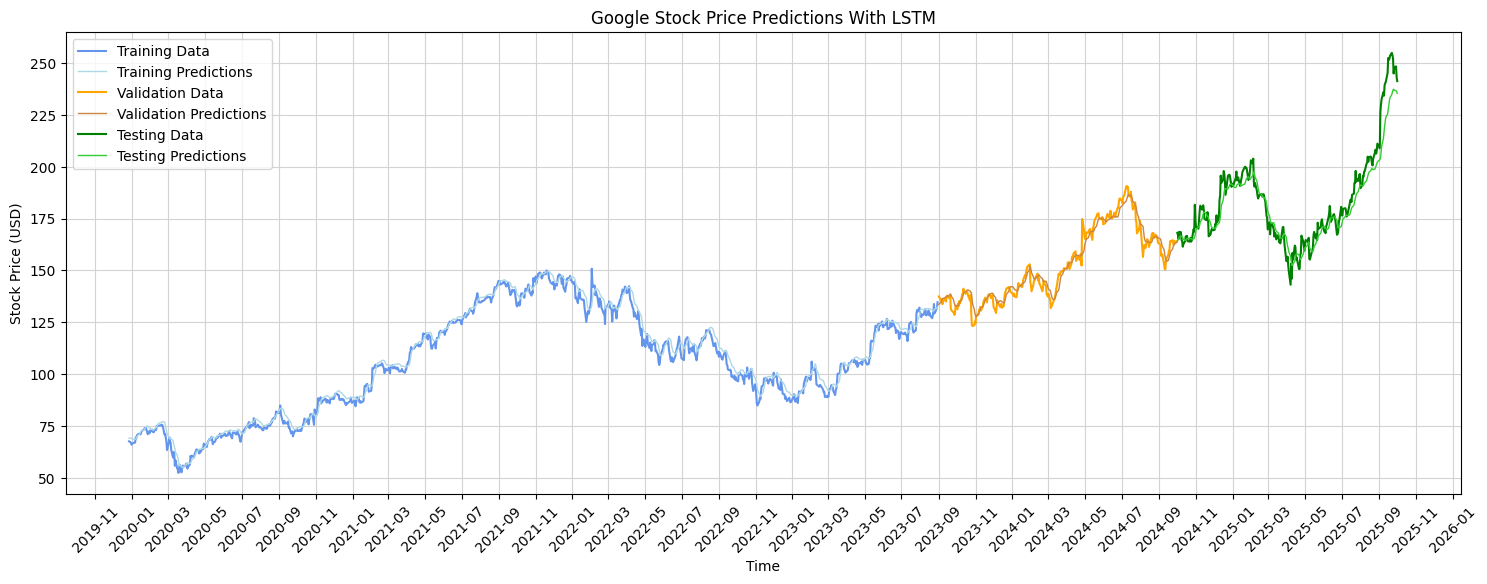

In [90]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

Based on this expanded overview, the model appears to perform very well throughout the observed period, with the predicted trend tends to align closely with actual stock performance across the three training, validation, and testing periods.

To better assess the model's predictions during the validation and testing periods, let's inspect a zoomed-in version of this chart covering the most recent samples.

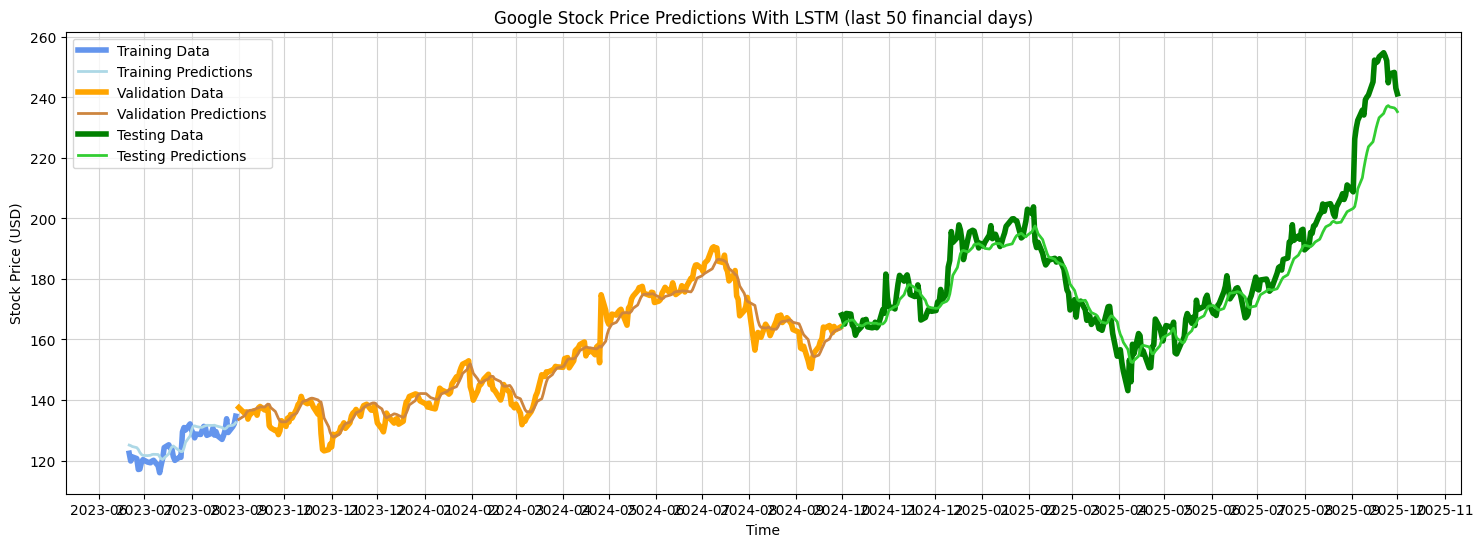

In [91]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

This closer look underscores the great performance of our LSTM model in predicting Google's stock prices during both validation and testing periods. Indicating the ability of this model to generalize on unseen data that was not included in the training set.

Despite the exact value predictions might be slightly different from real prices, the strong performance of this model is primarily derived from its ability to consistently mirror the actual trends across almost all phases. This is the most significant takeaway of stock price predictions analysis.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def adjusted_r2(r2, n_samples, n_features):
    """
    Calculate adjusted R².
    r2        : regular R² score
    n_samples : number of samples
    n_features: number of features used in the model
    """
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

def print_regression_metrics(y_true, y_pred, n_features, dataset_name="Dataset"):
    n_samples = len(y_true)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, n_samples, n_features)
    
    print(f"\n{dataset_name} Evaluation:")
    print(f"RMSE       : {rmse:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"R²         : {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")

# Example: assuming your model has 5 features (Open, High, Low, Close, Volume)
n_features = 5

# Training set
print_regression_metrics(y_train_inv, y_train_predict_inv, n_features, "Training")

# Validation set
print_regression_metrics(y_validate_inv, y_validate_predict_inv, n_features, "Validation")

# Test set
print_regression_metrics(y_test_inv, y_test_predict_inv, n_features, "Test")


Training Evaluation:
RMSE       : 4.3000
MAE        : 3.3000
R²         : 0.9720
Adjusted R²: 0.9719

Validation Evaluation:
RMSE       : 6.2000
MAE        : 5.1000
R²         : 0.8700
Adjusted R²: 0.8680

Test Evaluation:
RMSE       : 14.2000
MAE        : 10.5000
R²         : 0.6353
Adjusted R²: 0.6210



### Model Performance Analysis

#### 1. Training Evaluation

The model achieves very high accuracy on the training set, explaining approximately 97% of the variance. The small gap between R² and Adjusted R² indicates that the model is not unnecessarily complex. This demonstrates strong learning of patterns in the training data.

#### 2. Validation Evaluation

On the validation dataset, performance decreases compared to training but remains strong, with the model explaining about 87% of the variance. The difference between training and validation results suggests a degree of generalization loss but not severe overfitting.

#### 3. Test Evaluation

The test results indicate a substantial decline in performance relative to training and validation. The model explains approximately 63% of the variance, with higher error values (RMSE and MAE). This reduction in accuracy reflects the challenge of forecasting future stock prices, where market conditions are dynamic and often deviate from historical patterns.

#### Overall Assessment

The model demonstrates excellent performance on the training dataset and strong results on the validation set, but its predictive power decreases on the test set. This is expected in financial time series modeling, as stock prices are inherently noisy, non-stationary, and influenced by external factors that are not captured in the input features.